# Предсказание температуры стали

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Нужно построить модель, которая предскажет температуру стали.

### Описание данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor

In [2]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

In [3]:
def precheck(df):
    print(df.info())
    print('Количество дубликатов: ', df.duplicated().sum())
    print('Количество уникальных партий: ', len(df['key'].unique()))
    print('Максимальный номер партии: ', df['key'].max())

Проведём первичный анализ данных, имеющихся в каждом датафрейме.

In [4]:
# данные об электродах
data_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


In [5]:
precheck(data_arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None
Количество дубликатов:  0
Количество уникальных партий:  3214
Максимальный номер партии:  3241


В `data_arc` следующие колонки:
- key
- Начало нагрева дугой
- Конец нагрева дугой
- Активная мощность
- Реактивная мощность

Особенности `data_arc`:
- Количество уникальных партий не совпадает с максимальным номером партии, есть пропущенные партии.
- Колонки 'Конец нагрева дугой' и 'Начало нагрева дугой' имеют тип данных, который нужно будет привести ко времени.

In [6]:
# данные о подаче сыпучих материалов (объём)
data_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


In [7]:
precheck(data_bulk)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None
Количество дубликатов:  0
Количество уникальных партий:  3129
Максимальный номер партии:  3241


В `data_bulk` следующие колонки:
- key
- Bulk 1
- Bulk 2
- ...
- Bulk 15

Видимо номера соответствуют определенным веществам, которые добавляют в расплавленную сталь.

Особенности `data_bulk`:
- Количество уникальных партий не совпадает с максимальным номером партии, есть пропущенные партии.
- Количество уникальных партий не совпадает с количеством в таблице `data_arc`.
- Пропуски в данных очевидно обусловлены тем, что в разных партиях добавляли разные вещества, и какие-то не добавляли.

In [8]:
# данные о подаче сыпучих материалов (время)
data_bulk_time

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27


In [9]:
precheck(data_bulk_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None
Количество дубликатов:  0
Количество уникальных партий:  3129
Максимальный номер партии:  3241


В `data_bulk_time` следующие колонки:
- key
- Bulk 1
- Bulk 2
- ...
- Bulk 15

Особенности `data_bulk_time`:
- Количество уникальных партий не совпадает с максимальным номером партии, есть пропущенные партии.
- Количество уникальных партий не совпадает с количеством в таблице `data_arc`.
- Количество уникальных партий совпадает с количеством в таблице `data_bulk`.
- Пропуски в данных очевидно обусловлены тем, что в разных партиях добавляли разные вещества, и какие-то не добавляли. Так как количества ненулевых строк в `data_bulk` и `data_bulk_time` одинаковы, скорее всего пропуски находятся в одинаковых строках. А информация об объеме и времени подачи сыпучих материалов видимо будет находиться в одинаковых пересечениях строк и столбцов.

In [10]:
# данные о продувке сплава газом
data_gas

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


In [11]:
precheck(data_gas)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None
Количество дубликатов:  0
Количество уникальных партий:  3239
Максимальный номер партии:  3241


В `data_gas` следующие колонки:
- key
- Газ 1

Особенности `data_gas`:
- Количество уникальных партий не совпадает с максимальным номером партии, есть пропущенные партии.
- Количество уникальных партий не совпадает с количеством в таблице `data_arc` и `data_bulk`.
- Что конкретно означает число в колонке "Газ 1" - не известно.

In [12]:
# результаты измерения температуры
data_temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [13]:
precheck(data_temp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None
Количество дубликатов:  0
Количество уникальных партий:  3216
Максимальный номер партии:  3241


В `data_temp` следующие колонки:
- key
- Время замера
- Температура

Особенности `data_temp`:
- Количество уникальных партий не совпадает с максимальным номером партии, есть пропущенные партии.
- Количество уникальных партий не совпадает с количеством в других таблицах.
- Для 2901 записи не указана температура. Соответственно, нужно проверить, есть ли хоть одно измерение температуры для тех партий, где температура неизвестна.

In [14]:
# данные о проволочных материалах (объём)
data_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
precheck(data_wire)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None
Количество дубликатов:  0
Количество уникальных партий:  3081
Максимальный номер партии:  3241


В `data_wire` следующие колонки:
- key
- Wire 1
- Wire 2
- ...
- Wire 9

Видимо номера соответствуют определенным металлам, которые добавляют в расплавленную сталь.

Особенности `data_wire`:
- Количество уникальных партий не совпадает с максимальным номером партии, есть пропущенные партии.
- Количество уникальных партий не совпадает с количеством в других таблицах.
- Пропуски в данных очевидно обусловлены тем, что в разных партиях добавляли разные металлы, и какие-то не добавляли.

In [16]:
# данные о проволочных материалах (время)
data_wire_time 

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
precheck(data_wire_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None
Количество дубликатов:  0
Количество уникальных партий:  3081
Максимальный номер партии:  3241


В `data_wire_time` следующие колонки:
- key
- Wire 1
- Wire 2
- ...
- Wire 9

Особенности `data_wire_time`:
- Количество уникальных партий не совпадает с максимальным номером партии, есть пропущенные партии.
- Количество уникальных партий не совпадает с количеством в других таблицах, кроме `data_wire`.
- Количество уникальных партий совпадает с количеством в таблице `data_wire`.
- Одинаковое количество ненулевых строк в `data_wire` и `data_wire_time` говорит о том, что пропуски находятся в одинаковых строках.

## Исследовательский анализ данных

Построим ящики с усами по данным мощности из таблицы `data_arc`.

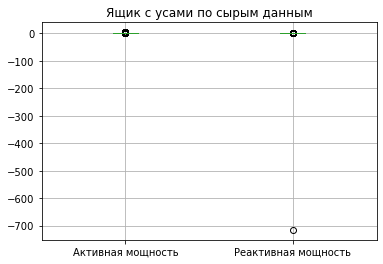

In [18]:
plt.title('Ящик с усами по сырым данным')
data_arc.boxplot(column = ['Активная мощность', 'Реактивная мощность']);

Отсеим явный выброс.

In [19]:
data_arc = data_arc.drop(index = data_arc.loc[(data_arc.loc[:,'Реактивная мощность'] < -100) ==True].index)

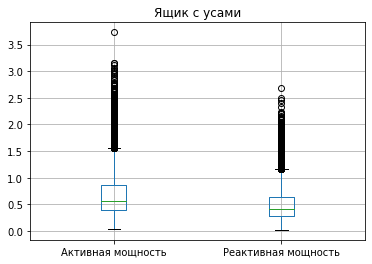

In [20]:
plt.title('Ящик с усами')
data_arc.boxplot(column = ['Активная мощность', 'Реактивная мощность']);

In [21]:
date_format='%Y-%m-%d %H:%M:%S'

In [22]:
# Функция возвращает Series с unix_time
def create_unix_time_column(df, column, format):
    unix_time = pd.to_datetime(df[column], format=format)
    return(unix_time)

In [23]:
# Функция возвращает Series с годом
def create_year_column(df, column, format):
    unix_time = pd.to_datetime(df[column], format=format)
    year_column = unix_time.dt.year
    return(year_column)

In [24]:
# Функция возвращает Series с месяцем
def create_month_column(df, column, format):
    unix_time = pd.to_datetime(df[column], format=format)
    month_column = unix_time.dt.month
    return(month_column)

In [25]:
# Функция возвращает Series с днём
def create_day_column(df, column, format):
    unix_time = pd.to_datetime(df[column], format=format)
    day_column = unix_time.dt.day
    return(day_column)

In [26]:
# Функция возвращает Series с днём недели
def create_weekday_column(df, column, format):
    unix_time = pd.to_datetime(df[column], format=format)
    weekday_column = unix_time.dt.weekday
    return(weekday_column)

In [27]:
# Функция возвращает Series с продолжительностью в секундах, вычисленной по разности между концом и началом процесса
def create_duration_column(df, column1, column2, format):
    unix_time1 = pd.to_datetime(df[column1], format=format)
    unix_time2 = pd.to_datetime(df[column2], format=format)
    unix_dif = unix_time2 - unix_time1
    seconds = unix_dif.dt.seconds
    return(seconds)

In [28]:
# Функция, которая вставляет в датафрейм колонки с годом, месяцем, числом месяца и днём недели 

def add_ymdwd_columns(df, prefix, datetime_str_columnname, format):
    """
    df - датафрейм, в который нужно вставить колонки
    prefix - префикс для имени новой колонки
    datetime_str_columnname - имя колонки, где лежит дата-время в строковом формате
    format - строка с форматом колонки datetime_str_columnname        
    """
    year_name = prefix + "year"
    df[year_name] = create_year_column(df, datetime_str_columnname, format)
    month_name = prefix + "month"
    df[month_name] = create_month_column(df, datetime_str_columnname, format)
    day_name = prefix + "day"
    df[day_name] = create_day_column(df, datetime_str_columnname, format)
    weekday_name = prefix + "weekday"
    df[weekday_name] = create_weekday_column(df, datetime_str_columnname, format)

Добавим столбцы с годом, месяцем, днём месяца и днём недели. Эти данные помогут нам при первичном анализе данных.

In [29]:
add_ymdwd_columns(data_arc, 'start_', 'Начало нагрева дугой', date_format)

Переведем формат колонок 'Начало нагрева дугой' и 'Конец нагрева дугой' к Unix.

In [30]:
data_arc['Начало нагрева дугой'] = create_unix_time_column(data_arc, 'Начало нагрева дугой', date_format)
data_arc['Конец нагрева дугой'] = create_unix_time_column(data_arc, 'Конец нагрева дугой', date_format)

In [31]:
data_arc['duration_s'] = create_duration_column(data_arc, 'Начало нагрева дугой', 'Конец нагрева дугой', date_format)

In [32]:
data_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,start_year,start_month,start_day,start_weekday,duration_s
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,2019,5,3,4,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,2019,5,3,4,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,2019,5,3,4,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,2019,5,3,4,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,2019,5,3,4,148
...,...,...,...,...,...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,2019,9,1,6,157
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,2019,9,1,6,180
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,2019,9,1,6,184
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,2019,9,1,6,57


Посмотрим, за какой период у нас имеются данные.

In [33]:
data_arc[['start_year', 'Активная мощность', 'Реактивная мощность']].pivot_table(index = 'start_year', 
                                                                                values = ['Активная мощность',
                                                                                         'Реактивная мощность'], 
                                                                                aggfunc = 'sum')

,Активная мощность,Реактивная мощность
start_year,,
2019,9972.99127,7448.259533


In [34]:
data_arc[['start_month', 'Активная мощность', 'Реактивная мощность']].pivot_table(index = 'start_month', 
                                                                                values = ['Активная мощность',
                                                                                         'Реактивная мощность'], 
                                                                                aggfunc = ('sum', 'count'))

Активная мощность              Реактивная мощность             
                        count          sum               count          sum
start_month                                                                
5                        3539  2429.450804                3539  1780.061910
6                        3987  2653.294985                3987  1964.643513
7                        3317  2248.404074                3317  1715.089226
8                        4014  2631.719123                4014  1981.173800
9                          18    10.122284                  18     7.291083

В нашем распоряжении данные с мая по сентябрь, причем сентябрь, очевидно, не полный.

Вычислим количество итераций запуска нагрева для каждой из партий. 

In [35]:
iterations_count = data_arc['key'].value_counts().reset_index()
iterations_count.set_axis(['key', 'count'], axis = 'columns', inplace = True)
iterations_count

,key,count
0,2108,16
1,1689,15
2,1513,15
3,2567,14
4,322,13
...,...,...
3209,977,1
3210,248,1
3211,556,1
3212,732,1


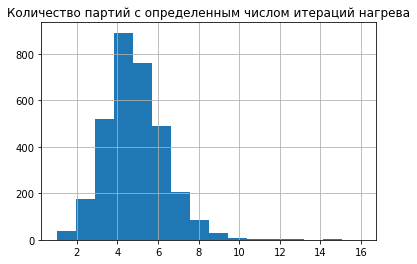

In [36]:
plt.title('Количество партий с определенным числом итераций нагрева')
iterations_count['count'].hist(bins=16);

Для партии №2108 потребовалось рекордное количество включений-выключений электродов - 16 раз. Но, самое распространенное количество итераций - 5.

Cгруппируем данные в `data_arc` по партиям, вычислим суммарно затраченные на нагрев время и мощность.

In [37]:
data_arc_pivot = data_arc[['key','Активная мощность', 'Реактивная мощность', 'duration_s']].pivot_table(index = 'key', 
                                                                                values = ['Активная мощность', 
                                                                                          'Реактивная мощность',
                                                                                          'duration_s'], 
                                                                                aggfunc = 'sum')
data_arc_pivot = data_arc_pivot.merge(iterations_count, on='key')
data_arc_pivot

,key,duration_s,Активная мощность,Реактивная мощность,count
0,1,1098,4.878147,3.183241,5
1,2,811,3.052598,1.998112,4
2,3,655,2.525882,1.599076,5
3,4,741,3.209250,2.060298,4
4,5,869,3.347173,2.252643,4
...,...,...,...,...,...
3209,3237,909,3.932467,2.828459,5
3210,3238,546,2.106529,1.681182,3
3211,3239,1216,4.666754,3.111617,8
3212,3240,839,2.984083,2.483267,5


Вернёмся к таблице `data_temp`. Удалим из неё строки с пропущенными значениями, приведем формат времени к Unix.

In [38]:
data_temp = data_temp.dropna()

In [39]:
data_temp['Время замера'] = create_unix_time_column(data_temp, 'Время замера', date_format)

In [40]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13006 entries, 0 to 15902
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13006 non-null  int64         
 1   Время замера  13006 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 406.4 KB


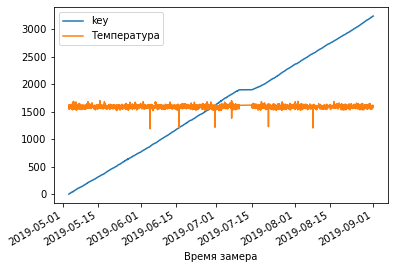

In [41]:
data_temp.set_index('Время замера').sort_index().plot();

Температуру стараются держать в определенном диапазоне около 1600 градусов.

Сгруппируем данные в `data_temp` по партиям, и вычислим среднюю температуру каждой партии.

In [42]:
data_temp_pivot = data_temp.pivot_table(index = 'key', values = 'Температура', aggfunc = 'mean')
data_temp_pivot

,Температура
key,
1,1601.400000
2,1593.500000
3,1597.800000
4,1616.333333
5,1589.000000
...,...
3237,1569.000000
3238,1584.000000
3239,1598.000000


Объединим по номеру партии данные из сводных таблиц.

In [43]:
data = data_arc_pivot.merge(data_temp_pivot, on = 'key')
data

,key,duration_s,Активная мощность,Реактивная мощность,count,Температура
0,1,1098,4.878147,3.183241,5,1601.400000
1,2,811,3.052598,1.998112,4,1593.500000
2,3,655,2.525882,1.599076,5,1597.800000
3,4,741,3.209250,2.060298,4,1616.333333
4,5,869,3.347173,2.252643,4,1589.000000
...,...,...,...,...,...,...
3209,3237,909,3.932467,2.828459,5,1569.000000
3210,3238,546,2.106529,1.681182,3,1584.000000
3211,3239,1216,4.666754,3.111617,8,1598.000000
3212,3240,839,2.984083,2.483267,5,1617.000000


Построим попарные точечные диаграммы для столбцов `data`.

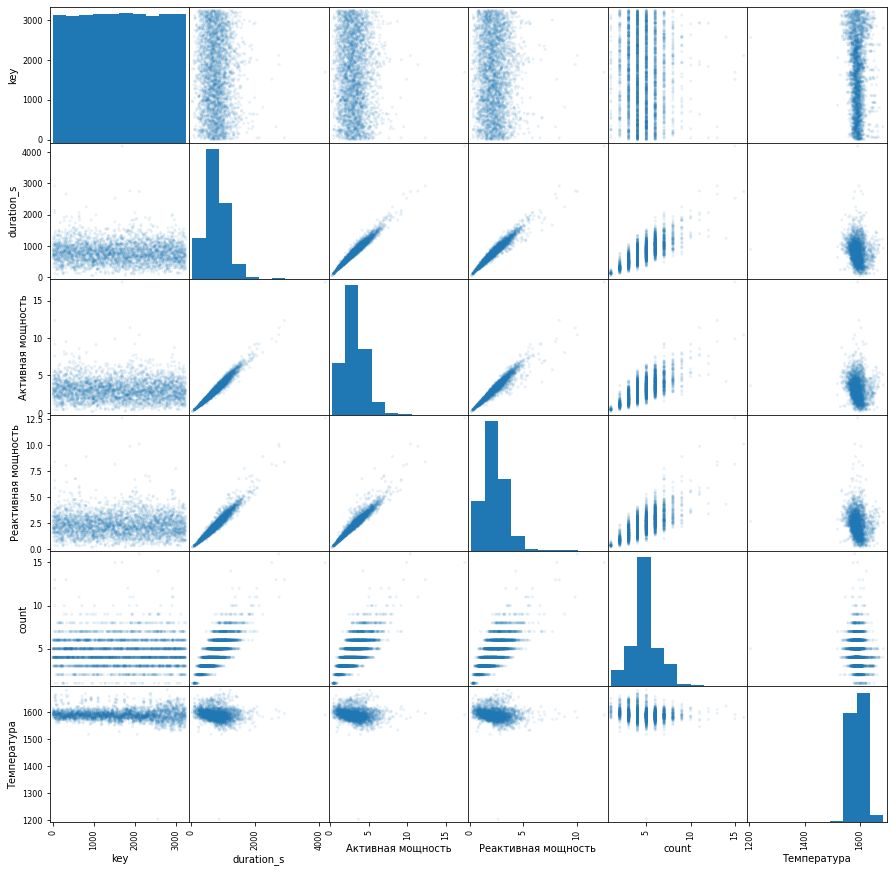

In [44]:
pd.plotting.scatter_matrix(data, figsize = (15,15), alpha = 0.1);

**Можно сделать следующие выводы:**
- Чем дольше нагревать сталь, тем больше энергии затрачивается (кэп).
- Одна и та же температура может быть достигнута при различных затратах электроэнергии.
- Одна и та же температура может быть достигнута при различном количестве итераций нагрева (count).
- На графике 'Температура-key' можно заметить странную тенденцию к большему разбросу температур у номеров партий начиная с 2500. 

Также можно предположить, что существуют партии, в которых из-за удачного сочетания пропорций добавляемых примесей и металлов, нужная температура достигается быстрее.

Избавимся от NaN в таблицах `data_bulk` и `data_wire`. 

In [45]:
data_bulk = data_bulk.fillna(0)
data_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0


In [46]:
data_wire = data_wire.fillna(0)
data_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3077,3238,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3078,3239,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3079,3240,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Так как в таблицах `data_bulk` и `data_wire` одной партии соответствует одно значение добавленного вещества, объединим эти таблицы с `data`. А таблицы `data_bulk_time` и `data_wire_time` в этом случае не нужны.

**Предположительно, таблица признаков будет выглядеть примерно так:**
 <a class="anchor" id="link"></a>

In [47]:
data = data.merge(data_bulk, on='key').merge(data_wire, on='key').merge(data_gas, on='key')
data.set_index('key')

,duration_s,Активная мощность,Реактивная мощность,count,Температура,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1
key,,,,,,,,,,,,,,,,,,,,,
1,1098,4.878147,3.183241,5,1601.400000,0.0,0.0,0.0,43.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
2,811,3.052598,1.998112,4,1593.500000,0.0,0.0,0.0,73.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
3,655,2.525882,1.599076,5,1597.800000,0.0,0.0,0.0,34.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
4,741,3.209250,2.060298,4,1616.333333,0.0,0.0,0.0,81.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
5,869,3.347173,2.252643,4,1589.000000,0.0,0.0,0.0,78.0,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3237,909,3.932467,2.828459,5,1569.000000,0.0,0.0,170.0,0.0,0.0,...,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.543905
3238,546,2.106529,1.681182,3,1584.000000,0.0,0.0,126.0,0.0,0.0,...,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.745669
3239,1216,4.666754,3.111617,8,1598.000000,0.0,0.0,0.0,0.0,0.0,...,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.023518


## Уточняющие вопросы

1. Какую именно температуру нужно предсказывать:
- среднюю по партии?
- минимальную или максимальную по партии?
- мгновенную?

*Ответ тимлида: последнюю по партии.*

2. Все ли признаки имеют одинаковые веса?

3. Какую метрику использовать для оценки качества модели?

*Ответ тимлида: MAE*

4. Есть ли отдельно тестовая выборка? Если нет, то делаем ли тестовую выборку? Какой объем данных отводим под тест? - 20% хватит?

*Ответ тимлида: отдельной тестовой выборки нет*

## Примерный план решения задачи

1. Получение обратной связи от тимлида.
2. Построение таблицы признаков. Предварительно таблица признаков выглядит [так](#link). Корректировка таблицы после ответа от тимлида.
3. Построение регрессионной модели. Выбор лучшей модели.
4. Тестирование лучшей модели.
5. Выводы.

## Построение таблицы признаков

В таблице `data_temp` содержатся данные об измерениях температур. Мы знаем, что для каждой партии как минимум автоматически должна быть измерена температура на входе в технологический процесс, и должна иметься температура на выходе. Последняя будет являться целевым признаком.

Однако, в таблице `data_temp` присутствуют партии, для которых есть только одно измерение температуры - первое. Таким образом, мы не знаем значения целевого признака. Найдём эти партии и удалим их из датафрейма.

Series с булевыми значениями True на месте партий с единственным измерением температуры:

In [48]:
is_key_1 = (data_temp.groupby('key').count()==1)['Температура']
is_key_1

key
1       False
2       False
3       False
4       False
5       False
        ...  
3237     True
3238     True
3239     True
3240     True
3241     True
Name: Температура, Length: 3216, dtype: bool

Список неподхлдящих для нашей задачи партий:

In [49]:
bad_keys = is_key_1.index[is_key_1 == True].tolist()
bad_keys

[195,
 279,
 2500,
 2501,
 2502,
 2503,
 2504,
 2505,
 2506,
 2507,
 2508,
 2509,
 2510,
 2511,
 2512,
 2513,
 2514,
 2515,
 2516,
 2517,
 2518,
 2519,
 2520,
 2521,
 2522,
 2523,
 2524,
 2525,
 2526,
 2527,
 2528,
 2529,
 2530,
 2531,
 2532,
 2533,
 2534,
 2535,
 2536,
 2537,
 2538,
 2539,
 2540,
 2541,
 2542,
 2543,
 2544,
 2545,
 2546,
 2547,
 2548,
 2549,
 2550,
 2551,
 2552,
 2553,
 2554,
 2555,
 2556,
 2557,
 2558,
 2559,
 2560,
 2561,
 2562,
 2563,
 2564,
 2565,
 2566,
 2567,
 2568,
 2569,
 2570,
 2571,
 2572,
 2573,
 2574,
 2575,
 2576,
 2577,
 2578,
 2579,
 2580,
 2581,
 2582,
 2583,
 2584,
 2585,
 2586,
 2587,
 2588,
 2589,
 2590,
 2591,
 2592,
 2593,
 2594,
 2595,
 2596,
 2597,
 2598,
 2599,
 2600,
 2601,
 2602,
 2603,
 2604,
 2605,
 2606,
 2607,
 2608,
 2609,
 2610,
 2611,
 2612,
 2613,
 2614,
 2615,
 2616,
 2617,
 2618,
 2619,
 2620,
 2621,
 2622,
 2623,
 2624,
 2625,
 2626,
 2627,
 2628,
 2629,
 2630,
 2631,
 2632,
 2633,
 2634,
 2635,
 2636,
 2637,
 2638,
 2639,
 2640,
 

Удалим "плохие" партии из датафрейма:

In [50]:
data_temp = data_temp[~data_temp['key'].isin(bad_keys)]
data_temp

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
12262,2498,2019-08-06 02:19:26,1593.0
12263,2498,2019-08-06 02:25:31,1594.0
12264,2499,2019-08-06 02:40:25,1569.0
12265,2499,2019-08-06 02:54:24,1604.0


Создадим таблицу с температурами на входе в технологический процесс. Для этого из таблицы `data_temp` выберем те строки, где у каждой из партий минимальное время замера.

In [51]:
data_temp_1 = data_temp.loc[data_temp.groupby('key')['Время замера'].idxmin()].set_index('key')
data_temp_1.columns = ['Время замера', 'Температура 1']
data_temp_1

,Время замера,Температура 1
key,,
1,2019-05-03 11:16:18,1571.0
2,2019-05-03 11:37:27,1581.0
3,2019-05-03 12:13:17,1596.0
4,2019-05-03 12:52:57,1601.0
5,2019-05-03 13:23:19,1576.0
...,...,...
2495,2019-08-06 00:35:45,1570.0
2496,2019-08-06 01:02:54,1554.0
2497,2019-08-06 01:41:53,1571.0


Создадим таблицу с последними замеренными температурами. Для этого из таблицы `data_temp` выберем те строки, где у каждой из партий максимальное время замера.

In [52]:
data_temp_out = data_temp.loc[data_temp.groupby('key')['Время замера'].idxmax()].set_index('key')
data_temp_out

,Время замера,Температура
key,,
1,2019-05-03 11:30:39,1613.0
2,2019-05-03 11:59:12,1602.0
3,2019-05-03 12:34:57,1599.0
4,2019-05-03 12:59:25,1625.0
5,2019-05-03 13:36:01,1602.0
...,...,...
2495,2019-08-06 00:54:42,1591.0
2496,2019-08-06 01:29:52,1591.0
2497,2019-08-06 01:53:50,1589.0


Построим финальную таблицу признаков.

In [53]:
data_final = data_arc_pivot.merge(data_temp_1['Температура 1'], on = 'key').\
                            merge(data_bulk, on='key').\
                            merge(data_wire, on='key').\
                            merge(data_gas, on='key').\
                            merge(data_temp_out['Температура'], on = 'key').set_index('key')
data_final

,duration_s,Активная мощность,Реактивная мощность,count,Температура 1,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1,Температура
key,,,,,,,,,,,,,,,,,,,,,
1,1098,4.878147,3.183241,5,1571.0,0.0,0.0,0.0,43.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986,1613.0
2,811,3.052598,1.998112,4,1581.0,0.0,0.0,0.0,73.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561,1602.0
3,655,2.525882,1.599076,5,1596.0,0.0,0.0,0.0,34.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793,1599.0
4,741,3.209250,2.060298,4,1601.0,0.0,0.0,0.0,81.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219,1625.0
5,869,3.347173,2.252643,4,1576.0,0.0,0.0,0.0,78.0,0.0,...,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692,1602.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,723,3.210690,2.360777,4,1570.0,0.0,0.0,21.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.125735,1591.0
2496,940,4.203064,2.810185,6,1554.0,0.0,0.0,0.0,63.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.412616,1591.0
2497,569,2.212379,1.851269,3,1571.0,0.0,0.0,0.0,85.0,0.0,...,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.271699,1589.0


Построим матрицу корреляций.

In [54]:
data_final.corr()

,duration_s,Активная мощность,Реактивная мощность,count,Температура 1,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1,Температура
duration_s,1.000000,0.978112,0.965474,0.799038,-0.304995,0.103047,0.038217,0.092682,-0.028237,0.013533,...,0.054543,0.033409,0.054802,NaN,0.042296,0.027619,0.017882,-0.011570,0.396306,0.278716
Активная мощность,0.978112,1.000000,0.958486,0.760613,-0.347621,0.084594,0.031090,0.112751,-0.031047,0.006517,...,0.054665,0.035638,0.047639,NaN,0.053341,0.019648,0.029493,-0.016158,0.373767,0.290434
Реактивная мощность,0.965474,0.958486,1.000000,0.755008,-0.325661,0.108948,0.052011,0.069320,-0.032370,0.018979,...,0.052309,0.030751,0.075687,NaN,0.055222,0.036900,0.016595,-0.012125,0.356824,0.240980
count,0.799038,0.760613,0.755008,1.000000,-0.141377,0.097788,0.093071,0.109238,-0.004237,0.075024,...,0.078237,0.055277,0.113648,NaN,0.053402,0.073662,0.043908,-0.024548,0.403947,0.181146
Температура 1,-0.304995,-0.347621,-0.325661,-0.141377,1.000000,0.072331,0.119802,-0.104394,0.144775,0.068389,...,-0.086089,-0.000178,0.064991,NaN,0.019884,0.044771,-0.023261,0.004310,0.037341,0.252443
Bulk 1,0.103047,0.084594,0.108948,0.097788,0.072331,1.000000,0.224701,-0.011628,0.041846,0.060429,...,-0.009229,0.020271,0.146301,NaN,0.148561,0.083443,-0.019535,0.011066,0.234141,-0.075206
Bulk 2,0.038217,0.031090,0.052011,0.093071,0.119802,0.224701,1.000000,-0.046888,0.040792,0.360302,...,-0.039058,0.223202,0.699342,NaN,0.558889,0.431737,-0.005273,-0.006842,0.217415,-0.082454
Bulk 3,0.092682,0.112751,0.069320,0.109238,-0.104394,-0.011628,-0.046888,1.000000,-0.295431,-0.006801,...,0.095723,0.005780,-0.040526,NaN,0.007113,-0.019448,0.004846,0.004621,0.059628,-0.035977
Bulk 4,-0.028237,-0.031047,-0.032370,-0.004237,0.144775,0.041846,0.040792,-0.295431,1.000000,0.028348,...,-0.268142,-0.039219,0.034421,NaN,-0.011417,0.033829,0.007830,-0.058138,0.017578,0.187970
Bulk 5,0.013533,0.006517,0.018979,0.075024,0.068389,0.060429,0.360302,-0.006801,0.028348,1.000000,...,-0.013794,0.070916,0.262763,NaN,0.204819,0.172141,-0.008337,-0.010817,0.086902,-0.028355


Похоже, 'Wire 5' не была добавлена ни в одну из партий. Проверим:

In [55]:
data_final['Wire 5'].value_counts()

0.0    2329
Name: Wire 5, dtype: int64

Удалим 'Wire 5' из признаков.

In [56]:
data_final = data_final.drop(columns='Wire 5')

Построим график матрицы корреляций для большей наглядности.

In [57]:
def CorrelationMatrix(df):
    f = plt.figure(figsize=(19, 15))
    plt.matshow(df.corr(), fignum=f.number)
    plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=90)
    plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title('Correlation Matrix', fontsize=16);

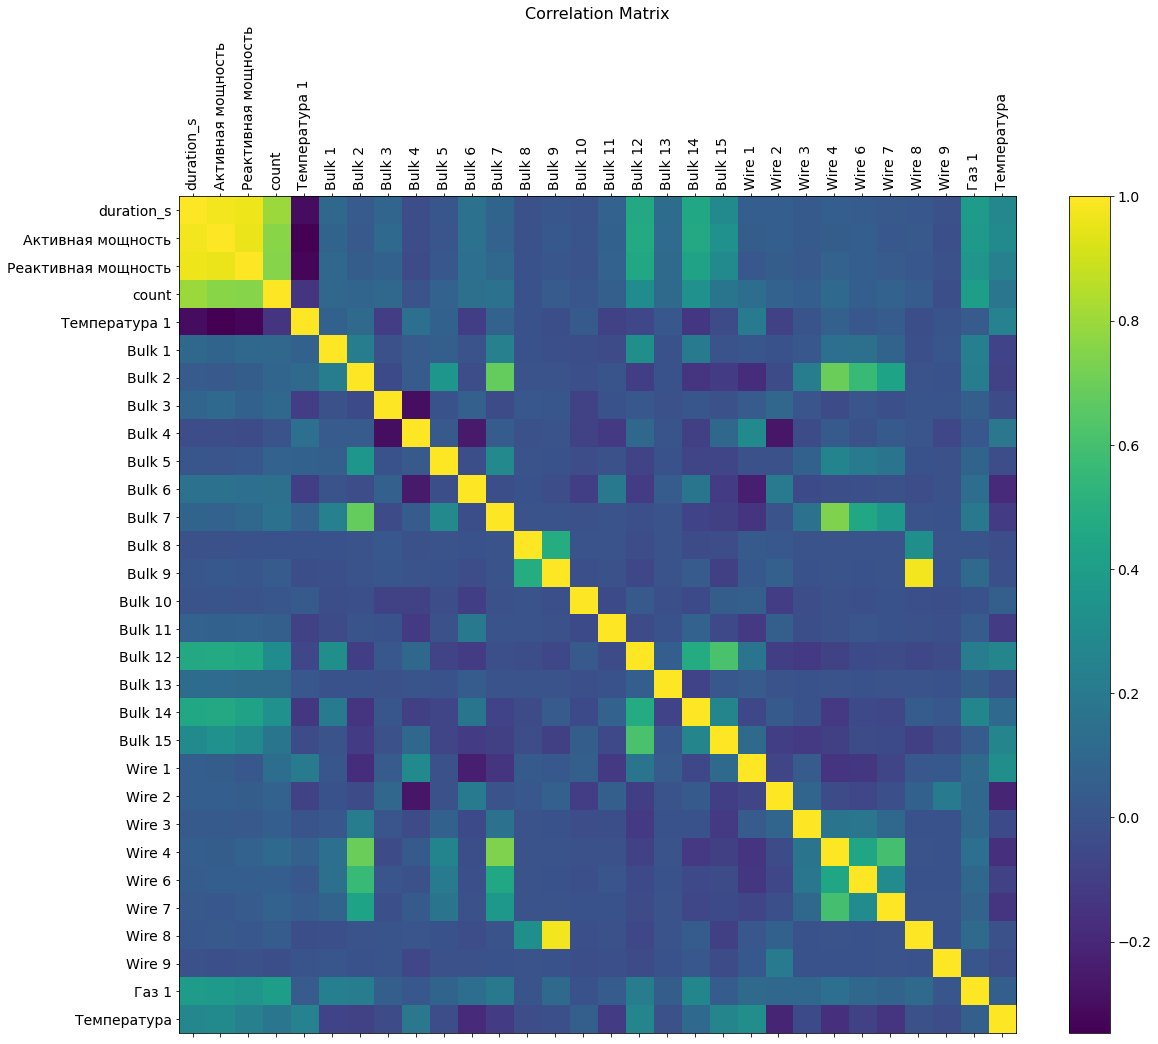

In [58]:
CorrelationMatrix(data_final)

Мы видим, что активная и реактивная мощности, а также количество итераций нагрева сильно коррелируют. Избавимся от мультиколлинеарности, удалив из признаков реактивную мощность и количество итераций нагрева.

In [59]:
data_final = data_final.drop(columns='Реактивная мощность')
data_final = data_final.drop(columns='count')

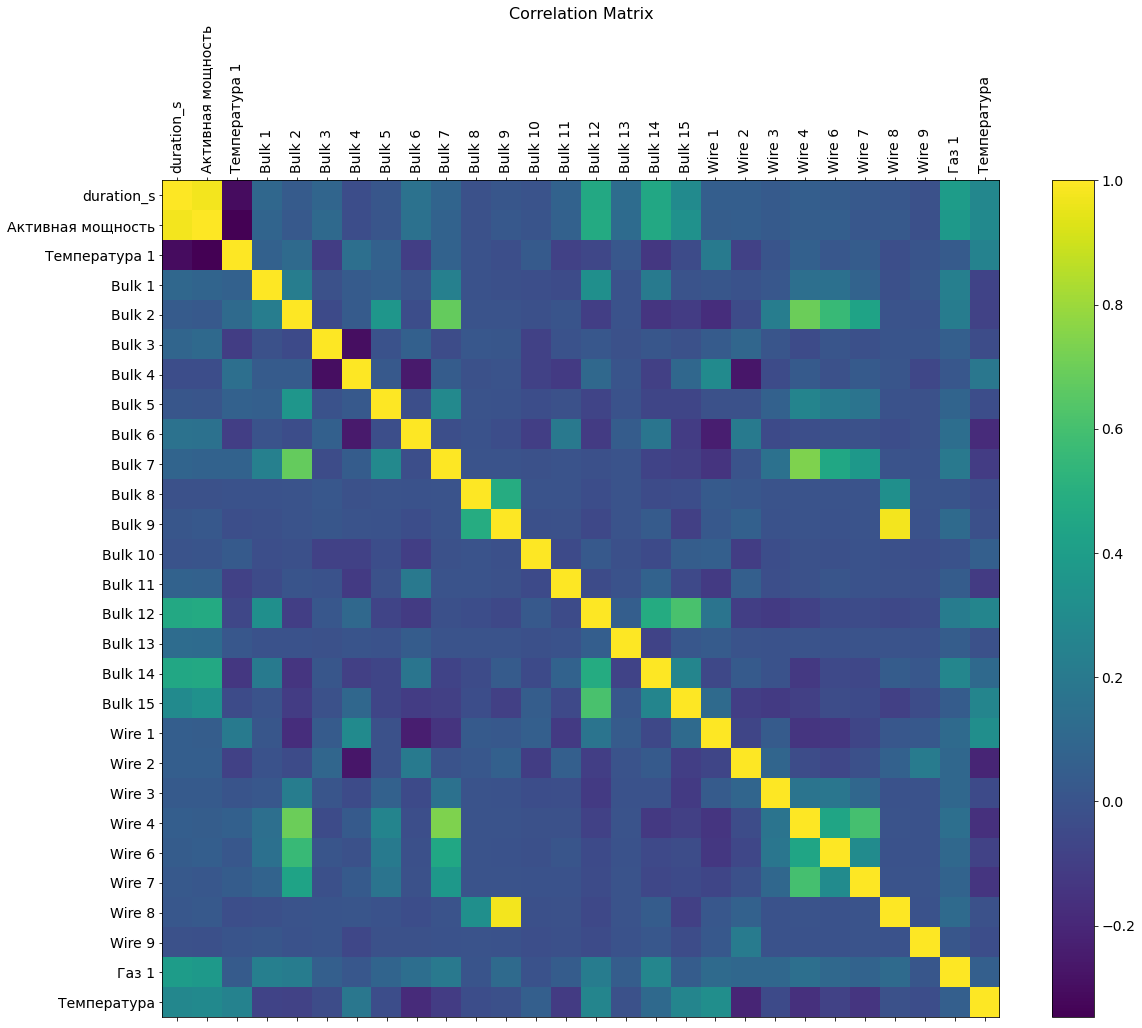

In [60]:
CorrelationMatrix(data_final)

**Финальная таблица признаков:**

In [61]:
data_final

,duration_s,Активная мощность,Температура 1,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1,Температура
key,,,,,,,,,,,,,,,,,,,,,
1,1098,4.878147,1571.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,29.749986,1613.0
2,811,3.052598,1581.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,12.555561,1602.0
3,655,2.525882,1596.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,28.554793,1599.0
4,741,3.209250,1601.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,18.841219,1625.0
5,869,3.347173,1576.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,5.413692,1602.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,723,3.210690,1570.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,...,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,7.125735,1591.0
2496,940,4.203064,1554.0,0.0,0.0,0.0,63.0,0.0,0.0,0.0,...,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,9.412616,1591.0
2497,569,2.212379,1571.0,0.0,0.0,0.0,85.0,0.0,0.0,0.0,...,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,6.271699,1589.0


## Построение моделей

Обучим несколько регрессионных моделей. Будем использовать в качестве метрики 'MAE'. Под тестовую выборку оставим 20% датасета `data_final`. 

In [62]:
# Функция удаляет выбранные столбцы из датафрейма
def drop_columns(df: pd.DataFrame, columns: list):
    df = df.drop(columns, axis=1)
    return df

In [63]:
# Функция возвращает предсказания лучшей модели и target_valid
def best_model(features_train, 
                  target_train,
                  model,
                  param_grid, 
                  cv, 
                  refit):
    
    my_scorer = {'MAE': make_scorer(mean_absolute_error, greater_is_better=False)}
    
    model = model
    grid = GridSearchCV(model, 
                        param_grid, 
                        cv=cv, 
                        refit=refit, 
                        scoring=my_scorer) 
    grid_result = grid.fit(features_train, target_train)
    best_model = grid_result.best_estimator_
    best_score = grid_result.best_score_
    best_params = grid.best_params_
    print(best_params)
    print(refit,":", best_score)
    return(best_model, best_score)

In [64]:
features = drop_columns(data_final, 'Температура')
target = data_final['Температура']

In [65]:
features

,duration_s,Активная мощность,Температура 1,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1
key,,,,,,,,,,,,,,,,,,,,,
1,1098,4.878147,1571.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
2,811,3.052598,1581.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
3,655,2.525882,1596.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
4,741,3.209250,1601.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
5,869,3.347173,1576.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,723,3.210690,1570.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,...,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,7.125735
2496,940,4.203064,1554.0,0.0,0.0,0.0,63.0,0.0,0.0,0.0,...,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,9.412616
2497,569,2.212379,1571.0,0.0,0.0,0.0,85.0,0.0,0.0,0.0,...,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,6.271699


In [66]:
features_train, features_test, target_train, target_test = \
train_test_split(features, target, test_size=0.2, random_state=12345)

In [67]:
features_train

,duration_s,Активная мощность,Температура 1,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1
key,,,,,,,,,,,,,,,,,,,,,
2432,490,1.808278,1590.0,0.0,0.0,61.0,0.0,0.0,0.0,0.0,...,204.0,105.094079,15.140320,0.0,0.0,0.0,0.0,0.0,0.0,4.059493
549,830,3.309889,1594.0,0.0,0.0,0.0,0.0,0.0,181.0,0.0,...,149.0,64.256393,24.128000,0.0,0.0,0.0,0.0,0.0,0.0,15.931603
1515,1769,6.423907,1595.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,209.0,65.005203,20.146879,0.0,0.0,0.0,0.0,0.0,0.0,22.008147
535,336,1.223886,1603.0,0.0,0.0,38.0,0.0,0.0,0.0,0.0,...,106.0,165.344403,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,6.423889
1845,1083,4.600184,1585.0,0.0,0.0,0.0,133.0,0.0,0.0,0.0,...,208.0,114.893997,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,8.325121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2302,506,1.797199,1620.0,0.0,0.0,110.0,67.0,0.0,0.0,0.0,...,0.0,66.000473,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,7.340110
593,476,1.879100,1604.0,0.0,0.0,0.0,109.0,0.0,0.0,0.0,...,103.0,63.367203,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,8.196447
426,612,2.426073,1588.0,0.0,0.0,0.0,94.0,0.0,0.0,0.0,...,223.0,160.383591,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,7.241311


In [68]:
# Функция для построения графика важности признаков
def feature_impotances(importances, features):
    std = np.std([importances], axis=0)
    feature_names = features.columns.to_list()
    importances_series = pd.Series(importances, index=feature_names)
    fig, ax = plt.subplots()
    importances_series.plot.bar(yerr=std, ax=ax, figsize=(10, 7))
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

In [69]:
# Сетка параметров для линейной регрессии
PARAM_GRID_LR = {'fit_intercept': [False, True],
              'normalize': [False, True],
             'n_jobs': [-1, None]}  
PARAM_GRID_LR;

In [70]:
%%time
model_LR, MAE_LR = best_model(features_train, 
                  target_train,
                  LinearRegression(),
                  #PARAM_GRID_LR, 
                  {'fit_intercept': [True], 'n_jobs': [-1], 'normalize': [True]}, #для проверки времени обучения
                  5, 
                  'MAE')

{'fit_intercept': True, 'n_jobs': -1, 'normalize': True}
MAE : -7.528791631079919
Wall time: 44.2 ms


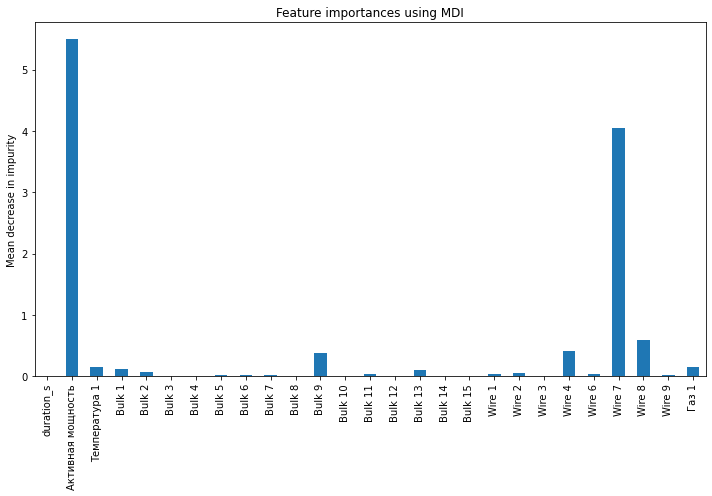

In [71]:
feature_impotances(abs(model_LR.coef_), features_train)

In [72]:
# Сетка параметров для DecisionTreeRegressor()
PARAM_GRID_DTR = {'splitter': ['best', 'random'],
                  'max_depth': range(1,10),
                  'min_samples_leaf': range(1,5),
                 'random_state': [12345]}  
PARAM_GRID_DTR;

In [73]:
%%time
model_DTR, MAE_DTR = best_model(features_train, 
                  target_train,
                  DecisionTreeRegressor(),
                  #PARAM_GRID_DTR, 
                  {'max_depth': [5], 'min_samples_leaf': [4], 'random_state': [12345], 'splitter': ['best']}, #для проверки времени обучения
                  5, 
                  'MAE')

{'max_depth': 5, 'min_samples_leaf': 4, 'random_state': 12345, 'splitter': 'best'}
MAE : -6.812715509767024
Wall time: 66.8 ms


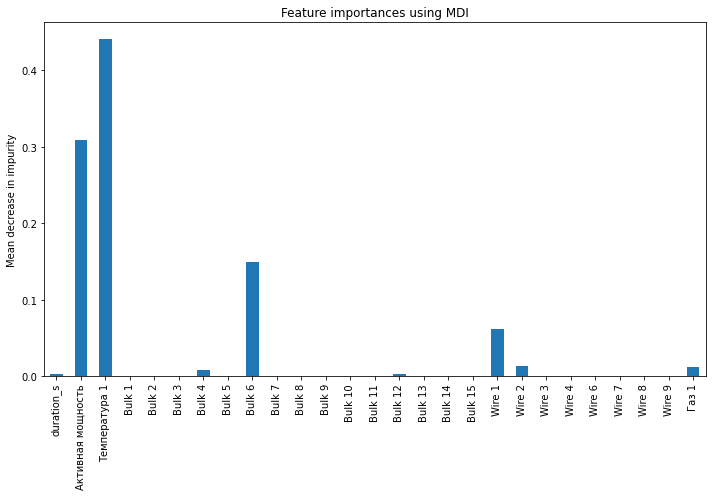

In [74]:
feature_impotances(model_DTR.feature_importances_, features_train)

In [75]:
# Сетка параметров для RandomForestRegressor()
PARAM_GRID_RFR = {'n_estimators': [3,  10,  31, 100], #np.logspace(0, 2, 5, endpoint=True, dtype = 'int')
                  'max_depth': range(1,5),
                  #'min_samples_leaf': range(1,5),
                 'random_state': [12345]}  
PARAM_GRID_RFR;

In [76]:
%%time
model_RFR, MAE_RFR = best_model(features_train, 
                  target_train,
                  RandomForestRegressor(),
                  #PARAM_GRID_RFR, 
                  {'max_depth': [4], 'n_estimators': [100], 'random_state': [12345]}, #для проверки времени обучения
                  5, 
                  'MAE')

{'max_depth': 4, 'n_estimators': 100, 'random_state': 12345}
MAE : -6.583051645461934
Wall time: 2.17 s


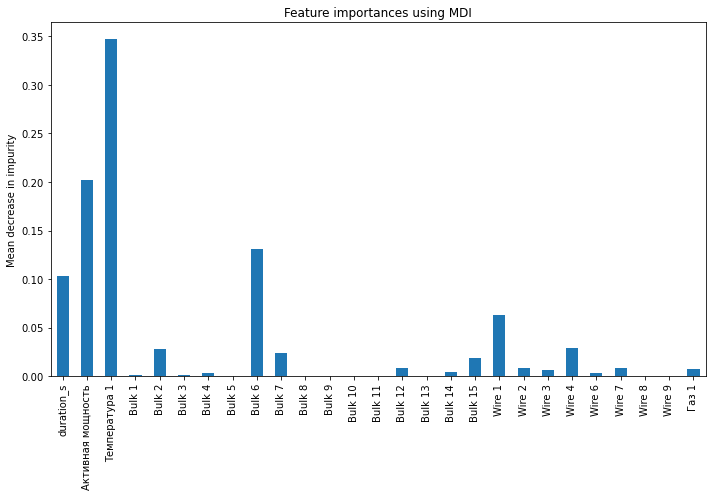

In [77]:
feature_impotances(model_RFR.feature_importances_, features_train)

In [78]:
# Сетка параметров для GradientBoostingRegressor()
PARAM_GRID_GBR = {'learning_rate': [0.2 ,0.5, 0.7],
                  'max_depth': range(1,5),
                  'random_state': [12345],
                  #'verbose': [1]
                  }  
PARAM_GRID_GBR;

In [79]:
%%time
model_GBR, MAE_GBR = best_model(features_train, 
                  target_train,
                  GradientBoostingRegressor(),
                  #PARAM_GRID_GBR, 
                  {'learning_rate': [0.2], 'max_depth': [4], 'random_state': [12345]}, #для проверки времени обучения
                  5, 
                  'MAE')

{'learning_rate': 0.2, 'max_depth': 4, 'random_state': 12345}
MAE : -6.056776450096976
Wall time: 2.61 s


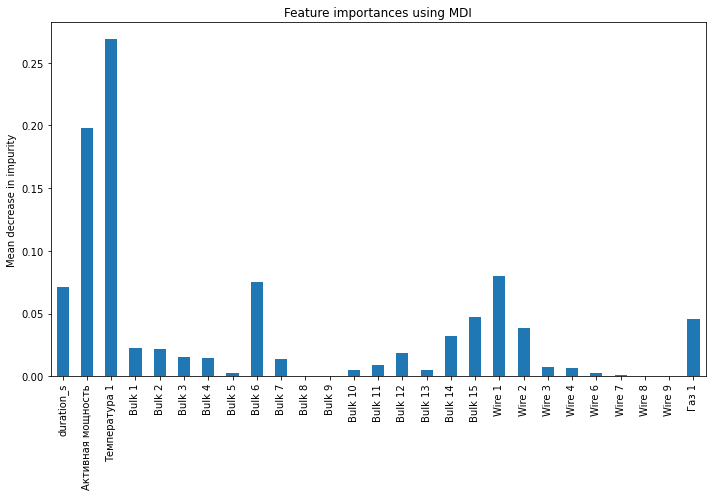

In [80]:
feature_impotances(model_GBR.feature_importances_, features_train)

In [81]:
# Сетка параметров для CatBoostRegressor()
PARAM_GRID_CBR = {'learning_rate': [0.1, 0.2 ,0.5, 0.7],
                  'iterations': [50 ,100, 200, 300, 400],
                  'depth': range(1,5),
                  'random_state': [12345],
                  'verbose': [0]
                  }  
PARAM_GRID_CBR;

In [82]:
%%time
model_CBR, MAE_CBR = best_model(features_train, 
                  target_train,
                  CatBoostRegressor(),
                  #PARAM_GRID_CBR, 
                  {'depth': [4], 'iterations': [300], 'learning_rate': [0.1], 'random_state': [12345], 'verbose': [0]},  #для проверки времени обучения
                  5, 
                  'MAE')

{'depth': 4, 'iterations': 300, 'learning_rate': 0.1, 'random_state': 12345, 'verbose': 0}
MAE : -5.937056559158329
Wall time: 2.7 s


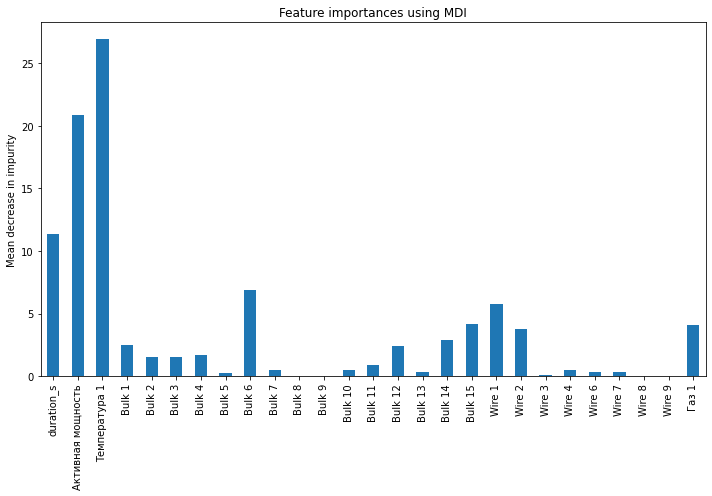

In [83]:
feature_impotances(model_CBR.get_feature_importance(), features_train)

## Анализ моделей

После обучения моделей и подбора гиперпараметров, мы обучили модели еще раз уже с выигравшими гиперпараметрами для того, чтобы приблизительно сравнить время, требуемое для обучения. Сведём эти значения и полученные значения метрики 'MAE' в таблицу.

In [84]:
compare_models = pd.DataFrame({
    'Модель': ['LinearRegression', 
               'DecisionTreeRegressor', 
               'RandomForestRegressor',
               'GradientBoostingRegressor',
               'CatBoostRegressor'],
    'MAE': [-MAE_LR.round(2), 
            -MAE_DTR.round(2),
            -MAE_RFR.round(2),
            -MAE_GBR.round(2),
            -MAE_CBR.round(2)],
    'Время обучения': [0.0509,
                       0.0678,
                       2.16,
                       2.59,
                       2.67]

}).set_index('Модель')
compare_models

,MAE,Время обучения
Модель,,
LinearRegression,7.53,0.0509
DecisionTreeRegressor,6.81,0.0678
RandomForestRegressor,6.58,2.1600
GradientBoostingRegressor,6.06,2.5900
CatBoostRegressor,5.94,2.6700


Для большей наглядности построим графики.

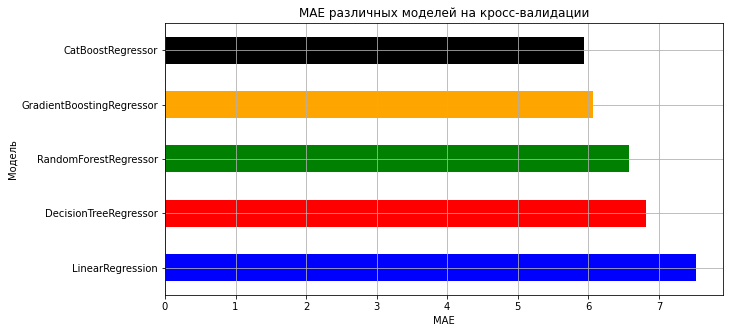

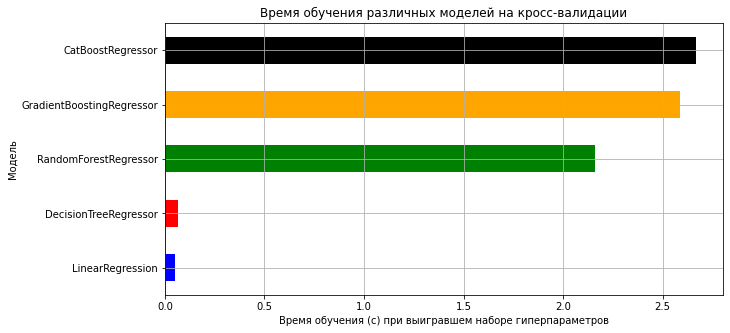

In [85]:
plt.title('MAE различных моделей на кросс-валидации')
plt.xlabel('MAE')
compare_models['MAE'].plot(kind='barh',
                           linewidth=5, 
                           color=('blue', 'red', 'green', 'orange', 'black'),
                           figsize=(10, 5), 
                           grid=True)
plt.show()

plt.title('Время обучения различных моделей на кросс-валидации')
plt.xlabel('Время обучения (с) при выигравшем наборе гиперпараметров')
compare_models['Время обучения'].plot(kind='barh',
                           linewidth=5, 
                           color=('blue', 'red', 'green', 'orange', 'black'),
                           figsize=(10, 5), 
                           grid=True)
plt.show()

Выбираем модель CatBoostRegressor `model_CBR`, как показавшую наименьшее значение ошибки.

Повторим график важности признаков для модели CatBoostRegressor.

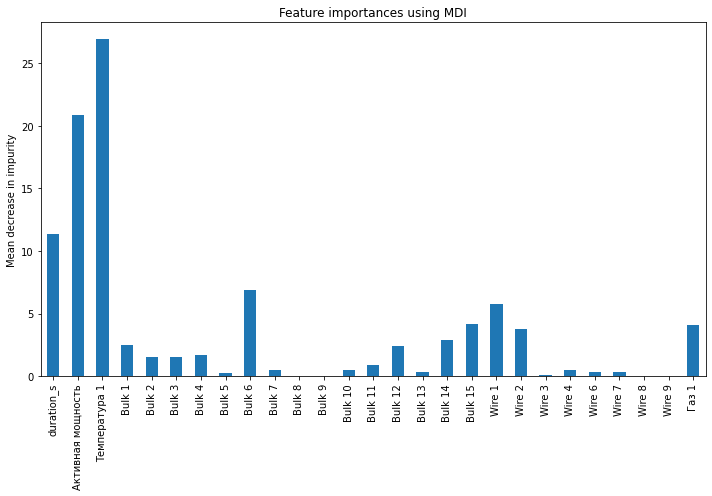

In [86]:
feature_impotances(model_CBR.get_feature_importance(), features_train)

Для нашей модели оказались наименее важны следующие признаки:
- Bulk 8
- Bulk 9
- Wire 3
- Wire 8
- Wire 9

## Проверка на тестовой выборке

Проверим модель-победитель на тестовой выборке.

In [87]:
predictions = model_CBR.predict(features_test)
mean_absolute_error(target_test, predictions)

5.936359849260069

Мы получили хорошее значение метрики.

# Итог

- Проведён исследовательский анализ данных.
- Составлена таблица признаков для обучения моделей.
- Мы обучили и проверили качество нескольких различных моделей.
- Две различных модели градиентного бустинга показали хорошие результаты при валидации.
- Несмотря на высокую скорость, модели DecisionTreeRegressor и LinearRegression показали результаты скромнее.
- Модель CatBoostRegressor `model_CBR` показала лучшие результаты.
- Модель-победитель прошла проверку на тестовой выборке.

# Отчёт

После проведения исследовательского анализа данных план выглядел так:

1. *Получение обратной связи от тимлида.*
2. *Построение таблицы признаков. Предварительно таблица признаков выглядит [так](#link). Корректировка таблицы после ответа от тимлида.*
3. *Построение регрессионной модели. Выбор лучшей модели.*
4. *Тестирование лучшей модели.*
5. *Выводы.*

Все пункты плана были выполнены:

1. Обратная связь от тимлида получена.
2. Финальная таблица признаков построена с учётом корректировок после ответа тимлида.
3. Обучены несколько моделей, проведён сравнительный анализ качества моделей на обучающей выборке с использованием кросс-валидации. Выбрана лучшая модель (CatBoostRegressor).
4. Модель победитель прошла проверку на тестовой выборке.
5. Был подведён итог.

Возникшие трудности:

1. Первая возникшее затруднение - это размытая постановка задачи. 
- Решилась после обратной связи от тимлида.
2. Основная трудность заключалась в составлении таблицы признаков и предобработке данных. 
- Из исходных датасетов были выделены нужные. Эти датасеты были преобразованы и сгруппированы по партиям.

Ключевые шаги в решении задачи:
1. Определение целевого признака как температуры на выходе технологического процесса. Удаление из таблицы `data_temp` партий только с одним измерением температуры. 
2. Создание дополнительных признаков: 
- 1-го измерения температуры ('Температура 1') из `data_temp`,
- суммарной продолжительности нагрева ('duration_s') из разности времени окончания и начала нагрева из таблицы `data_arc`.
3. Объединение таблиц в финальную таблицу признаков `data_final`.
4. Удаление сильно скоррелированных признаков.
5. Обучение нескольких моделей с различными гиперпараметрами с использованием кросс-валидации. Выбор модели с наименьшей ошибкой.
6. Тестирование лучшей модели.

Итоговая модель - CatBoostRegressor `model_CBR` показала лучшие результаты. MAE = 5.936 на тестовой выборке.